# Identification of Damage in Rolling bearings using machine learning algorithms
*Author:* German Martinez-Ayuso  


**Work inspired/based on:**

A.P. Daga, A. Fasana, S. Marchesiello, L. Garibaldi, *The Politecnico di Torino rolling bearing test rig: Description and analysis of open access data*, Mechanical Systems and Signal Processing 120 (2019) 252–273. doi:10.1016/j.ymssp.2018.10.010.

Date: July 6th 2024


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Pre-processing</a></span><ul class="toc-item"><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Importing libraries</a></span></li><li><span><a href="#Reading-the-data-files" data-toc-modified-id="Reading-the-data-files-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Reading the data files</a></span></li><li><span><a href="#Reading-the-data-files" data-toc-modified-id="Reading-the-data-files-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Reading the data files</a></span></li><li><span><a href="#Calculating-variables:" data-toc-modified-id="Calculating-variables:-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Calculating variables:</a></span></li><li><span><a href="#Profiling-the-data-reading" data-toc-modified-id="Profiling-the-data-reading-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Profiling the data reading</a></span></li><li><span><a href="#Normalizing" data-toc-modified-id="Normalizing-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Normalizing</a></span></li></ul></li><li><span><a href="#Correlation-study" data-toc-modified-id="Correlation-study-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Correlation study</a></span></li><li><span><a href="#Principal-Component-Analysis-(PCA)" data-toc-modified-id="Principal-Component-Analysis-(PCA)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Principal Component Analysis (PCA)</a></span><ul class="toc-item"><li><span><a href="#Discussion" data-toc-modified-id="Discussion-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Discussion</a></span><ul class="toc-item"><li><span><a href="#Speed" data-toc-modified-id="Speed-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Speed</a></span></li><li><span><a href="#Damage" data-toc-modified-id="Damage-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Damage</a></span></li><li><span><a href="#Load" data-toc-modified-id="Load-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Load</a></span></li><li><span><a href="#Speed-Damage" data-toc-modified-id="Speed-Damage-3.1.4"><span class="toc-item-num">3.1.4&nbsp;&nbsp;</span>Speed-Damage</a></span></li><li><span><a href="#Speed-Load" data-toc-modified-id="Speed-Load-3.1.5"><span class="toc-item-num">3.1.5&nbsp;&nbsp;</span>Speed-Load</a></span></li></ul></li></ul></li><li><span><a href="#K-Means-clustering-analysis" data-toc-modified-id="K-Means-clustering-analysis-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>K-Means clustering analysis</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>


For printing to PDF: `jupyter nbconvert file.ipynb --to pdf`

## Literature review


Moved to the latex file.


## Pre-processing

### Importing libraries

In [1]:
# %qtconsole
import numpy as np
import pandas as pd
import seaborn as sns; sns.set() 

# %matplotlib qt 
%matplotlib inline

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
colors = sns.color_palette("GnBu", 7)
sns.set_palette('GnBu',n_colors=7) # sequential 
sns.set_palette('hls',n_colors=7) # for difference

from tikzplotlib import save as save_tex 
from tikzplotlib import clean_figure

import scipy.io as sio

from IPython.core.debugger import set_trace #For debugging if needed.

### Reading the file names. 

Getting the names and number of files.

In [2]:
# import scipy.io as sio

# test = sio.loadmat('VariableSpeedAndLoad/FileNames.mat')
# file_names = test['FileNames']

# file_names = [each_name[0:-4] for each_name in file_names]

The number of files is {{len(file_names)}}.

### Reading the data files

We are going to run this once, and save the output. If needed to re-read the files, uncomment the next cell.


In [3]:
# data = {} # Pre-allocating

# for each_file in file_names:     
#     # raw
#     data[each_file] = sio.loadmat('VariableSpeedAndLoad/'+each_file)[each_file]

# %store data
# %store -r data

### Calculating variables:

The authors use the root mean square, skewness, kurtosis, peak (or maximum) and the crest factor to 'compress' the data. 
They apply these functions to chunks of data of 0.1s. 

In [4]:
# functions 
def root_mean_square(x):
    return (((x**2).sum())/x.count())**0.5 # Based on numpy array (.count)

def skewness(x): 
    return x.skew()

def kurtosis(x):
    return x.kurtosis()

def peak_value(x):
    return x.max()

def crest_factor(x):
    return abs(x.max())/root_mean_square(x)

The next cell convert the dict data to a dataframe. 

This takes a while, so we are going to run this once, and save the output. If needed to re-read the files, uncomment the next cell.


In [5]:
def convert_data_to_df(data=None):
    dff = pd.DataFrame()
    dfff = pd.DataFrame()

    #To normalize the load. 
    poss_load = [0,500,700,900]

    for ind, each_file in enumerate(file_names):     
        
        # post 
        if data:
            data_ = data[each_file]
        else:
            data_ = sio.loadmat('VariableSpeedAndLoad/'+each_file)[each_file]
        
        df = pd.DataFrame(data_)
        dff = pd.DataFrame()

        dff['Test'] = [int(ind) for i in range(100)] # using int here to get int32 instead of int64
        dff['Test_name'] = [each_file for i in range(100)]
        dff['Fault'] = [int(each_file[1]) for i in range(100)]
        dff['Speed'] = [int(each_file.split('_')[1]) for i in range(100)]

        # dff['Load'] = [int(each_file.split('_')[2]) for i in range(100)]  
        load_ = min(poss_load, key=lambda x:abs(x-int(each_file.split('_')[2])))
        dff['Load'] = [load_  for i in range(100)]  

        volt_ = int(each_file.split('_')[2])
        dff['Volt'] = [volt_ for i in range(100)] 
        dff['Reps'] = [int(each_file.split('_')[3]) for i in range(100)]   

        index = df.index//5120
        group = df.groupby(index)

        parameters_ = ['RMS_ch_', 'skew_ch_', 'kurt_ch_', 'peak_ch_', 'crest_ch_']
        funs = [root_mean_square, skewness, kurtosis, peak_value, crest_factor]

        for each_parameter,each_function in zip(parameters_,funs):
            headers = [each_parameter+str(each_column) for each_column in df.columns]
            dff[headers] = group.apply(each_function)
        
        if dff['RMS_ch_0'].isnull().values.any() or dff['RMS_ch_0'].isna().values.any():
            print(each_file)
            print('Nan: {}'.format(dff.isnull().sum()))
        
        dfff = pd.concat([dfff,dff],ignore_index =True) #Slower

    return dfff

## Uncomment next if needed. 
# df_sec = convert_data_to_df()
# df = df_sec #Using df_sec for security. 
 

## Store dataframe
# Two options, use the magic %store (not compatible with google drive syncronization) or use HDFS store from pandas. 
# We will use the second. 

# %store df df_sec
# backup = pd.HDFStore('backup.h5')
# backup['df'] = df
# backup['df_sec'] = df_sec
# backup.close()
# df.to_excel('df.xlsx', engine='xlsxwriter') # Other option is to export to Excel.


# load data previously calculated
# %store -r df
backup = pd.HDFStore('backup.h5')
df = backup['df']
# df_sec=backup['df_sec']
file_names = df.Test_name.unique().tolist()


### Profiling the data reading

For the sake of optimization.

In [6]:
# The previous convert_data function takes ages, so I did some profiling.
# Uncomment if needed. 

# import cProfile
# pr = cProfile.Profile()                # create a cProfiler object 
# pr.enable()                            # turn profiling on
# pr.runcall( convert_data_to_df, data)  # profile my function
# pr.disable()                           # turn profiling off 

In [7]:
# ## Analysing profile data
# import pstats
# p = pstats.Stats(pr)           # create pstats obj based on profiler above.
# p.sort_stats('tottime').print_stats(20) ;

Initial time spend on the function `convert_data_to_df` was 245s and I got it down to 144s.

### Normalizing

There is two options to scale the data with respect to:
- Healthy data (A0)
- Everything

I think it makes more sense to scale with respect to the healthy data since this is the reference.



In [8]:
from sklearn.preprocessing import StandardScaler

# Columns which do not content text. 
columns_text = ['Test_name','Test','Fault','Speed','Load','Reps','Volt']

# With respect to the healthy data. 
df_0 = df[df['Test']==0]
col = df.columns.drop(columns_text)

# Option 1
#df[col] = df[col].subtract(df_0[col].mean())

# Option 2 
scaler = StandardScaler(with_mean=True,with_std=False).fit(df_0[col])
df[col] = scaler.transform(df[col])


The average data for the healthy set is:

In [9]:
pd.DataFrame(df_0[col].mean()).T

,RMS_ch_0,RMS_ch_1,RMS_ch_2,RMS_ch_3,RMS_ch_4,RMS_ch_5,skew_ch_0,skew_ch_1,skew_ch_2,skew_ch_3,...,peak_ch_2,peak_ch_3,peak_ch_4,peak_ch_5,crest_ch_0,crest_ch_1,crest_ch_2,crest_ch_3,crest_ch_4,crest_ch_5
0,3.038447,4.880384,5.480262,7.602007,7.380601,5.51694,0.00495,0.04663,-0.006832,0.071529,...,9.77462,23.152107,11.617461,11.939955,3.689141,1.809887,1.783606,3.04562,1.574111,2.164341


## Correlation study

Importing libraries

In [10]:
# Importing algorithms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.spatial import ConvexHull # To draw the 'wrapping' lines.

# Getting unique values 
loads_ = df['Load'].unique()
speeds_ = df['Speed'].unique()
faults_ = df['Fault'].unique()
order_damage = np.array([0,3,6,2,5,1,4])


It is always useful to plot the covariance matrix when we use PCA since this algorithm try to maximize the variance of each component. 



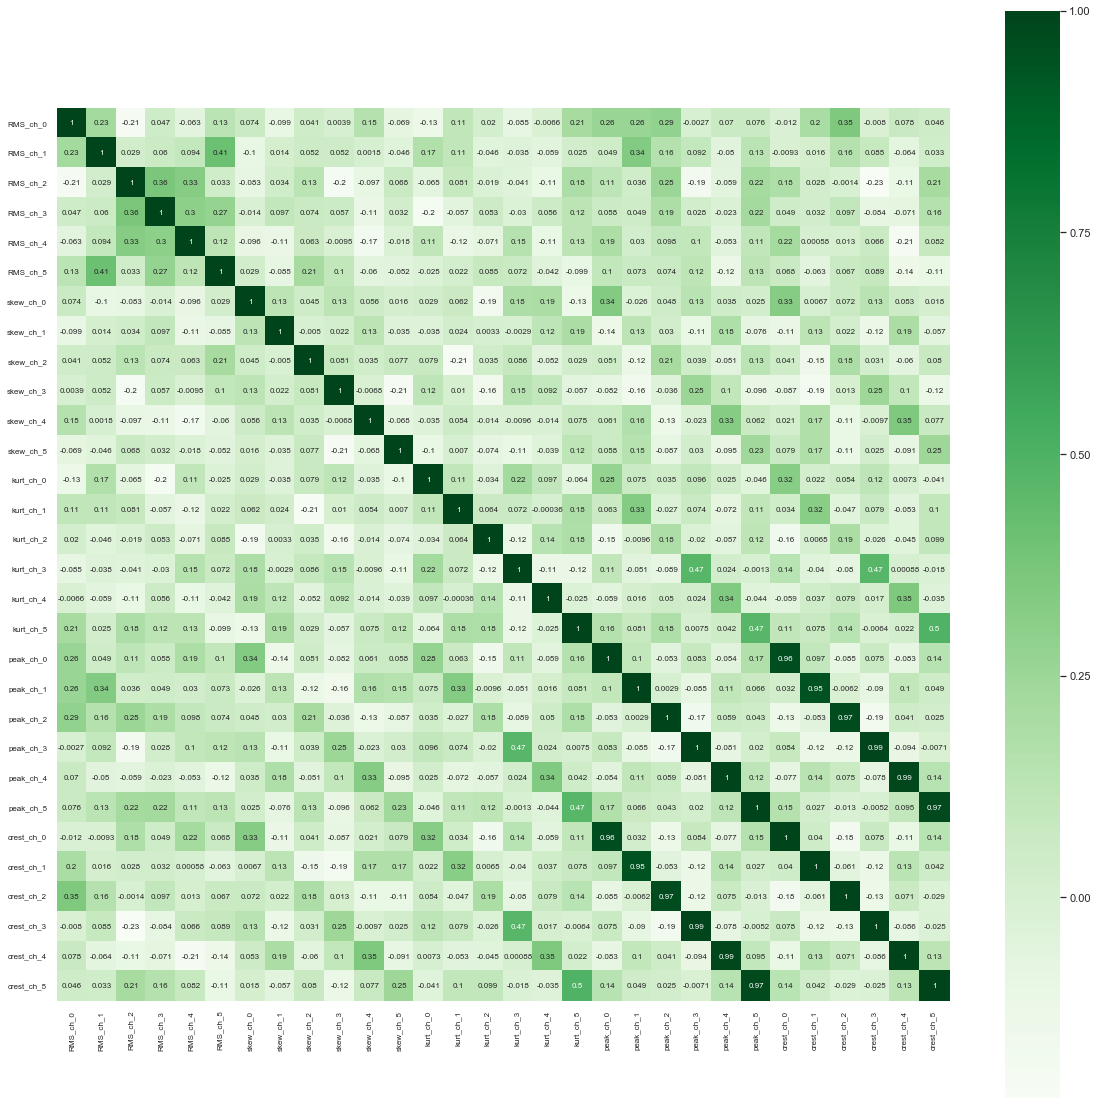

In [11]:
fig = plt.figure(figsize=(20,20))

cor_ = df_0[col].corr()
g = sns.heatmap(cor_,square=True,annot=True,cmap='Greens', annot_kws={"size": 8});
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 8);
g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 8);

As we can see there is strong correlation between the crest and the peaks which makes sense.

Also we can try to see relationship between the channels:

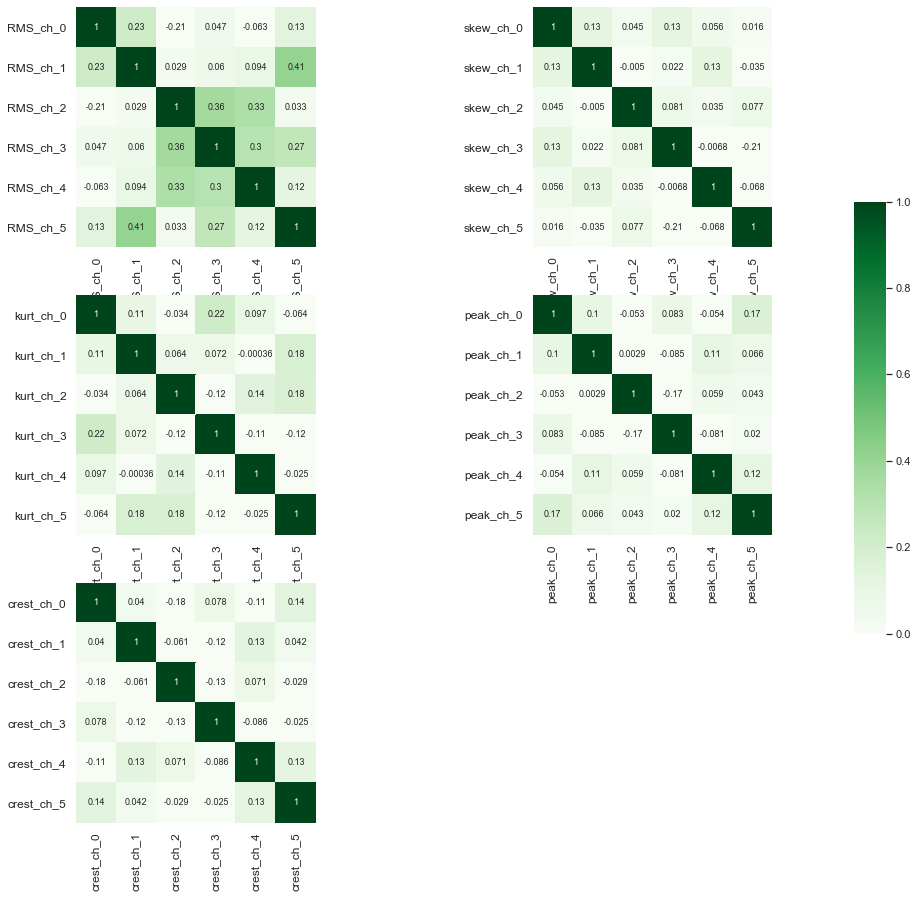

In [12]:
def plot_corr_channels(df_0):
    fig = plt.figure(figsize=(15,15))
    ax = fig.subplots(nrows=3,ncols=2)#,sharex=True,sharey=True)
    cbar_ax = fig.add_axes([.91, .3, .03, .4]) # for the color bar

    cor_ = df_0.filter(regex='RMS',axis=1).corr()
    sns.heatmap(cor_,square=True,annot=True,cmap='Greens',ax=ax[0,0], annot_kws={"size": 9},vmin =0, vmax=1, cbar=False);
    # g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 8);
    # g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 8);

    cor_ = df_0.filter(regex='skew',axis=1).corr()
    sns.heatmap(cor_,square=True,annot=True,cmap='Greens',ax=ax[0,1], annot_kws={"size": 9},vmin =0, vmax=1, cbar_ax=cbar_ax); 

    cor_ = df_0.filter(regex='kurt',axis=1).corr()
    sns.heatmap(cor_,square=True,annot=True,cmap='Greens',ax=ax[1,0], annot_kws={"size": 9},vmin =0, vmax=1, cbar=False);

    cor_ = df_0.filter(regex='peak',axis=1).corr()
    sns.heatmap(cor_,square=True,annot=True,cmap='Greens',ax=ax[1,1], annot_kws={"size": 9},vmin =0, vmax=1, cbar=False);

    cor_ = df_0.filter(regex='crest',axis=1).corr()
    sns.heatmap(cor_,square=True,annot=True,cmap='Greens',ax=ax[2,0], annot_kws={"size": 9},vmin =0, vmax=1, cbar=False);

    # hidding the empty plot
    ax[2,1].set_visible(False)

    # Changing font size
    for each_ax in ax.flatten():    
        each_ax.set_xticklabels(each_ax.get_xmajorticklabels(), fontsize = 12);
        each_ax.set_yticklabels(each_ax.get_ymajorticklabels(), fontsize = 12);
    
    return fig 

fig = plot_corr_channels(df_0)
fig.savefig('Figures/corrchannels.png')
save_tex('Figures_tex/corrchannels.tex',axis_width=r'\figurewidth', axis_height=r'\figureheight')

Checking the RMS, we can see the channels 1 and 5 are quite correlated as well as channels 2, 3 and 4. 

However, the rest of the variables shows no relationship.

Let's have a look now to the damaged test (fault=4)


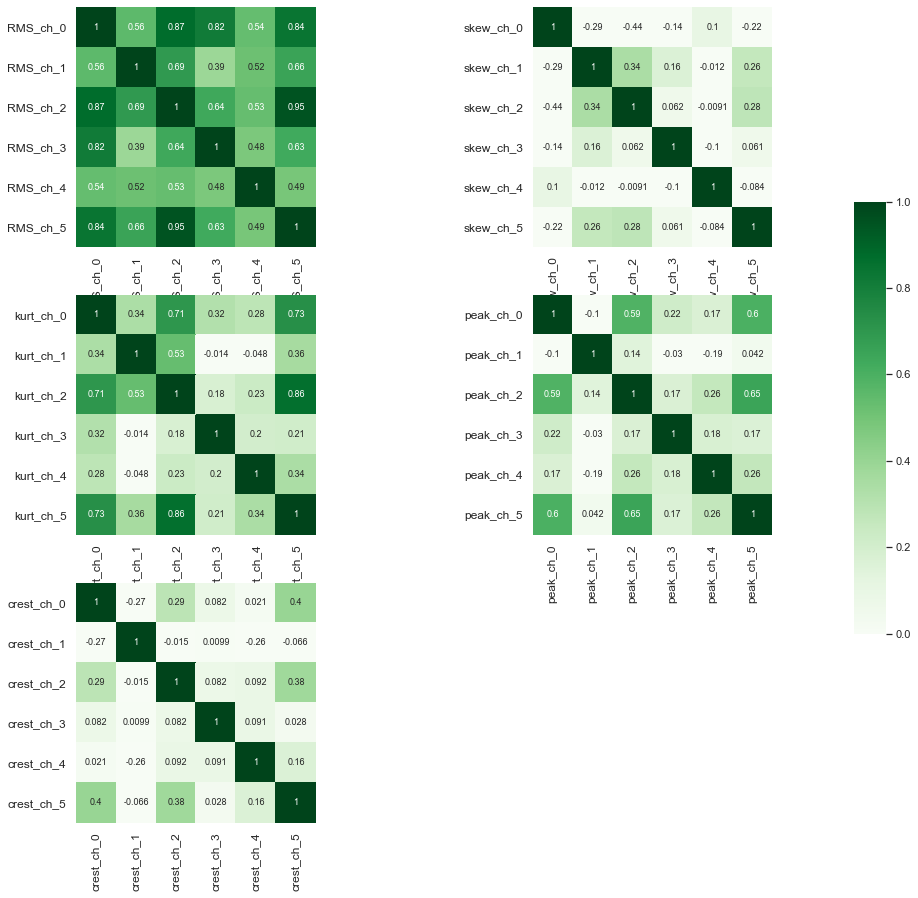

In [13]:
df_f = df[
            (df['Fault'] == 4) 
            & (df['Speed'] == speeds_[0])
            & (df['Load'] == loads_[0])
        ]

fig = plot_corr_channels(df_f)
fig.savefig('Figures/corrchannels_defect.png')
save_tex('Figures_tex/corrchannels_defect.tex',
         axis_width=r'\figurewidth', axis_height=r'\figureheight')

It should be noticed that this test has minimal load and speed. 

It is interesting to see how the RMS of all channels is highly related. There are more indicators of correlation for the test with defect than for the case without defects. 

I would have expected some correlation between channels with the same direction (0-3, 1-4 and 2-5), but I can't see it this expected relationship using the correlation analysis. 

|      *    | Channel 0 | Channel 1 | Channel 2 | Channel 3 | Channel 4 | Channel 5 |
| --- | --- | --- | --- | --- | --- | --- |
| Direction | Axial, x  | Radial, y | Radial, z | Axial, x  | Radial, y | Radial, z |

## Principal Component Analysis (PCA)

Let's proceed to do a principal component analysis in order to compress the data in a lower dimensional dataset. This way, we might be able to see relationships between variables and configurations.

More information about PCA can be found in the corresponding article in the Wikipedia [[PCA-Wikipedia]](https://en.wikipedia.org/wiki/Principal_component_analysis).


The PCA needs to be provided with the number of components the lower dimensional data is going to have. 
There is no mechanism to calculate directly the optimal number of components, rather it is recommended to run different simulations with multiples number of components and check the most appropriate. 
To obtain the number of components we will use the whole dataset (faulty and non-faulty) in order to account for the variability of all possible test. 

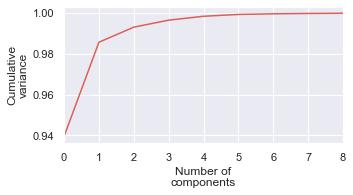

In [14]:
X = df.drop(columns_text,axis=1)  
pca = PCA().fit(X)

## Plotting
fig = plt.figure(figsize=(5,2.5)) 
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of\ncomponents')
plt.ylabel('Cumulative\nvariance');
plt.xlim([0,8]);

fig.savefig('Figures/pca_number_components.png')
save_tex('Figures_tex/pca_number_components.tex',axis_width=r'\figurewidth', axis_height=r'\figureheight')

With 2 components we have almost 100% of the explained variance. 
Three components do not offer any improvement. 

It is also preferred not to increase the number of components to 3 in order to keep the computational cost low and to keep the representations as 2D plots.

In [15]:
# We will use this quite a lot
def plot_clusters(dff, pca, legend=True, ax=None):

    dimen = 2

    if isinstance(ax, type(None)):
        ax_provided = False
    else:
        ax_provided = True

    if dimen == 2 and not ax_provided:

        fig = plt.figure(num=None, figsize=(8, 8), dpi=80)
        ax = fig.add_subplot(111)
    # I'm keeping the 3D options because it might be useful later.
    elif dimen == 3 and not ax_provided:
        fig = plt.figure(num=None, figsize=(8, 8), dpi=80)
        ax = fig.add_subplot(111, projection='3d')
    else:
        # print('Using previous axis')
        fig = None
        pass  # ax is supplied.

    test_ = dff['Test'].unique().tolist()
    test_.sort(reverse=True)

    for ind, each_ in enumerate(test_):
        # Filtering data for each test and drop the columns with text or without sensors.
        X = dff[dff['Test'] == each_].drop(columns_text, axis=1)

        # Getting extra data such as fault id, speed, load, etc.
        extra_data = [dff[dff['Test'] == each_][each].unique()[0]
                      for each in columns_text]

        # Transform
        X_pca = pca.transform(X)

        if dimen == 2:
            # To plot the healthy data differently
            if extra_data[2] == 0:  # healthy case
                marker = 'o'
                markeredgecolor = None
                s = 10
            else:
                marker = 'o'
                markeredgecolor = None
                s = 10

            # Plotting the convexhull (wrapping points)
            hull = ConvexHull(X_pca)
            simplex = hull.vertices.tolist()
            simplex.append(simplex[0])

            # Using the line of the convexhull to add the legend.
            # Shorter version for the legend
            label_ = "{}".format(extra_data[0])

            # Plotting convexhull
            ax.plot(X_pca[simplex, 0], X_pca[simplex, 1], marker=marker,
                    label=label_, markeredgecolor=markeredgecolor, ms=s/5)

            # Plotting scatter
            sns.scatterplot(X_pca[:, 0], X_pca[:, 1], marker=marker,
                            ax=ax, s=s, linewidth=0)  #

        # Not recommended.
        elif dimen == 3:
            PCA_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2', 'PC3'])
            sns.scatterplot(PCA_df['PC1'], PCA_df['PC2'],
                            marker='o',
                            )

    ax.set_xlabel('Principal Component 1', fontsize=12)
    ax.set_ylabel('Principal Component 2', fontsize=12)

    if dimen == 3:
        ax.set_zlabel('Principal Component 3', fontsize=12)

    # Sometimes the legend is very long, so let's give the option to hide.
    if legend and (not ax_provided):
        leg = plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.5), loc="lower left",
                         mode="expand", borderaxespad=0, ncol=3)
    else:
        leg = plt.legend([])

    plt.gca().invert_xaxis()  # Invert the axis to look close to fig 10.

    return fig, ax, leg  # (p1,p2)


Shape of the components (n_components,n_features)
(2, 30)

Explained variance:
[20150.35781569   258.02532617]

Principal directions expressed as a linear combination
of the features.
[[ 1.67940235e-01  8.14223413e-02  7.83746661e-02  1.14251317e-01
   5.55756967e-02  8.20387372e-02 -3.51543822e-05 -1.18450267e-05
   6.13305327e-05 -4.08677253e-05  2.34138888e-05 -7.79783028e-06
   2.98252801e-04  2.10976369e-05  1.79623112e-04  2.99808429e-04
   1.44618744e-04  1.92253354e-04  6.27792285e-01  2.98013444e-01
   3.09168159e-01  4.49105129e-01  2.39485365e-01  3.13938299e-01
   3.86161125e-04  1.69590083e-03  2.35119799e-03  1.09406092e-03
   3.62261812e-03  1.52851316e-03]
 [ 1.13323777e-01  5.09964092e-02  2.93869065e-02 -1.72742244e-01
   4.57106839e-02 -5.31802545e-02 -9.37461095e-05  7.35704043e-05
  -9.65011820e-04 -4.27305862e-04 -1.46338629e-04 -2.64762118e-04
   1.05839955e-03 -7.12722559e-03 -5.58439299e-04  4.31928143e-03
  -2.37759297e-03 -1.19786762e-03  6.40739540e-01 -5.5

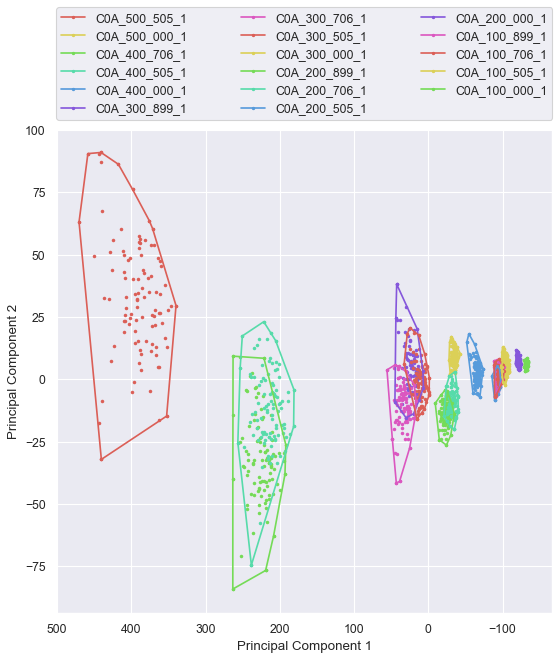

In [16]:
#Training on the non-faulty. Including all speeds and loads.
X = df[
    (df['Fault'].isin([0])) 
      ].drop(columns_text,axis=1) 

pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X) 

print('\nShape of the components (n_components,n_features)')
print(pca.components_.shape)

print('\nExplained variance:') # It measure the 'importance' of each component.
print(pca.explained_variance_)

print('\nPrincipal directions expressed as a linear combination\nof the features.')
print(pca.components_)


dff = df[
    (df['Fault'].isin([0])) 
      ]

plot_clusters(dff,pca);

Training PCA algorithm but only with the healthy data only. Considering all possible speeds and loads. 

In [17]:
# Training on the non-faulty
X = df[
    (df['Fault'].isin([0]))
].drop(columns_text, axis=1)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

Plotting the clusters for the healthy test (figure 10 in  Daga et all)

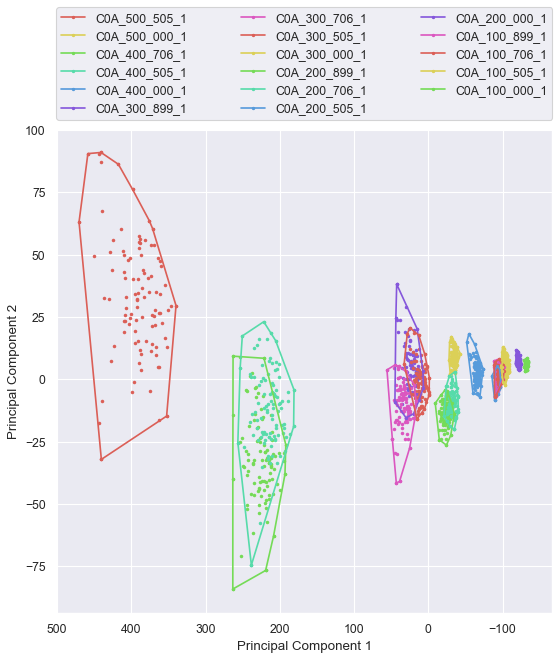

In [18]:
dff = df[(df['Fault'].isin(['0']))]

# Plotting fig 10
plot_clusters(dff, pca, legend=True);

Plotting figure 11. 

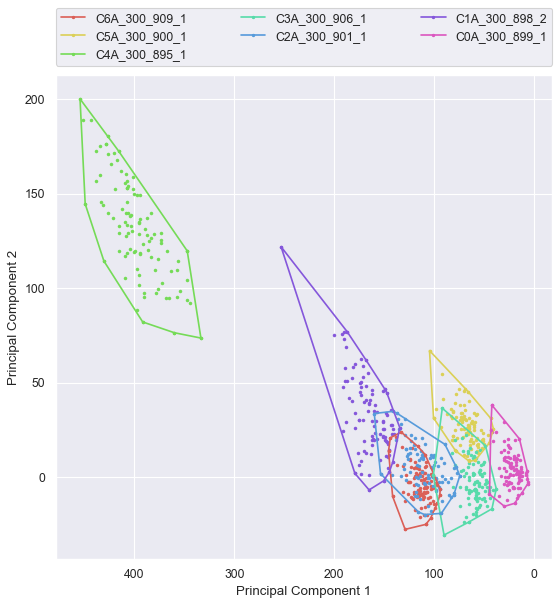

In [19]:
# working conditions (maximum load and half speed(300))

dff = df[
    (df['Speed'].isin([speeds_[2]]))    
    & (df['Load'].isin([loads_[-1]]))    
]
 
plot_clusters(dff,pca);

Plotting the non faulty and faulty PCA components for some possible combinations of speed and loads. 

In [20]:
def compare(speeds_=speeds_,loads_=loads_,faults_=faults_,title=None):
    """
    Super function to plot an array of subplots with each one one of the configuration of loads and speeds. 
    It plot in each subplot all the possible faults available. 
    """
    
    fig = plt.figure(figsize=(15,15))
    
    axs = fig.subplots(nrows=len(speeds_),ncols=len(loads_),sharex=False,sharey=False)
    axs_f = axs.flatten()
    for each_ax in axs_f:
        each_ax.set_visible(False) #Making all plot invisible, to hide the grid and so on. 
    
    handles= []
    labels = []

    for ind_speed, each_speed in enumerate(speeds_):#):
        for ind_load, each_load in enumerate(loads_): 
            for each_fault in faults_:
                dff = df[
                    (df['Speed']==each_speed)
                    & (df['Load'] == each_load)
                    & (df['Fault'] == each_fault)
                ]

                if len(dff)!=0: # because all the speeds are note available for all loads. 
                    _,ax,_ = plot_clusters(dff,pca,ax=axs[ind_speed,ind_load])

                    ax.set_title('Speed: {}-Load: {}'.format(each_speed,each_load))
                    ax.set_xlabel('')
                    ax.set_ylabel('')

                    handles_, labels_ = ax.get_legend_handles_labels()
                    leg= ax.get_legend()
                    leg.remove()

                    labels.extend(labels_)
                    handles.extend(handles_) 
                    ax.set_visible(True)

    labels_ = [each_handle.get_label().split('_')[0] for each_handle in handles]
    colors=[]
    for each_handle in handles:
        colors.append([round(each_num,8)  for each_num in list(each_handle.get_color())])

    if len(np.unique(labels_)) ==  len(np.unique(colors,axis=0)): 
        handles = fig.axes[0].get_legend_handles_labels()[0] 
        
        handles, labels = fig.axes[0].get_legend_handles_labels()
        # sort both labels and handles by labels
        labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: int(t[0][1])))
        labels = [each_label.split('_')[0] for each_label in labels]
        
        fig.legend(handles,labels, loc='center right')

    fig.subplots_adjust(top=0.9, left=0.1, right=0.9, bottom=0.12) 
    fig.tight_layout(rect=(0,0,0.90,0.95)) # expanding the plot
    fig.suptitle(title,fontweight='bold', fontsize=16)
    
    return fig

### Discussion

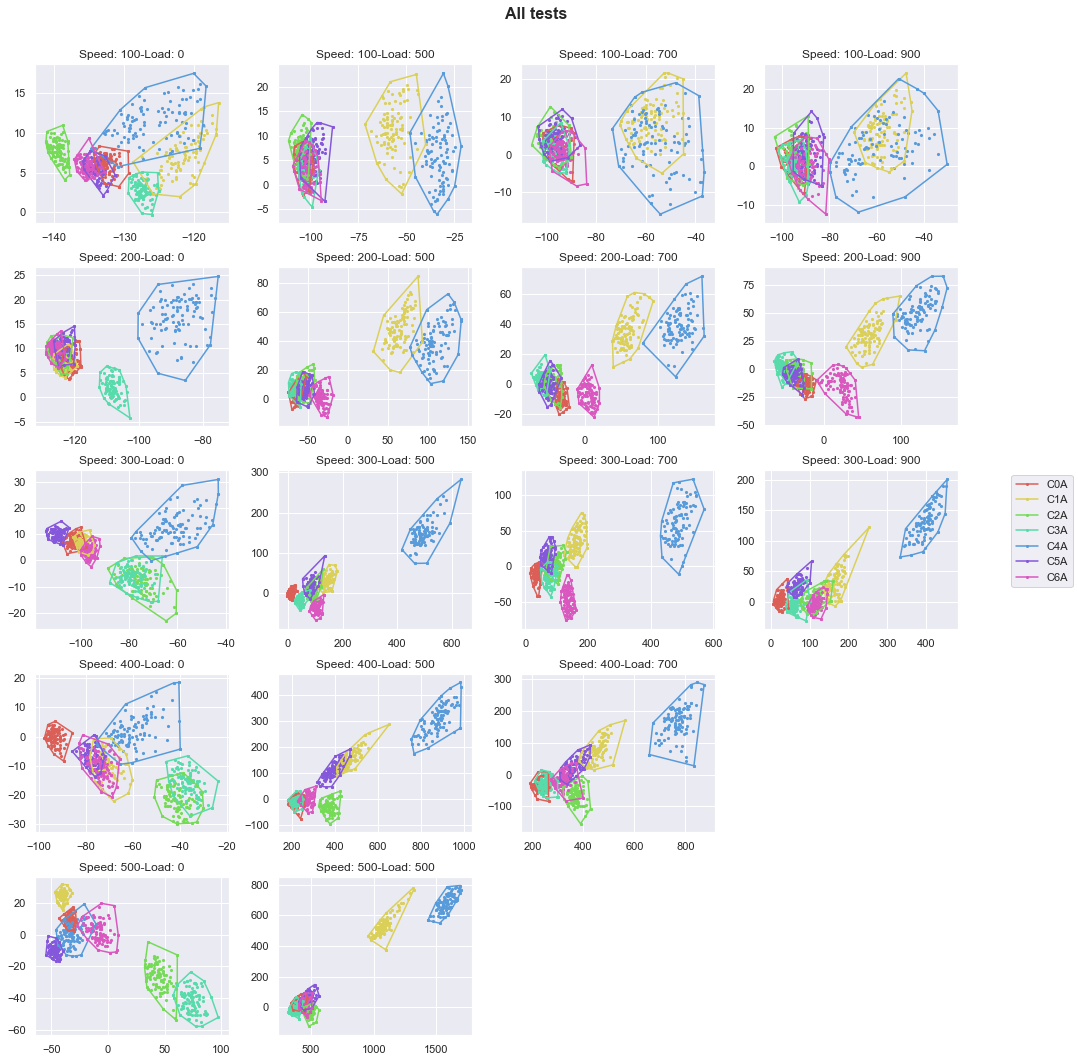

In [21]:
title = 'All tests'
fig = compare(title=title); #all 

It should be noticed that the faults in order (from no damage to high damage) is {{faults_[order_damage].tolist()}}
Hence the C0 is the non-damage and the C1 and C4 are the most damaged. 


- Next figure we can see plots of the high damaged and the non-damaged ones.
In general, the high damaged (HD) clusters are clearly separated from non-damaged (ND). So this means we should be able to detect when there is high damage by using the proposed set of data and approach (PCA). 
However, for the case with no load, the damage in the test 1 (indentation on the inner ring) is many times very similar to the non-damage. This might be due to the lack of load which makes the system to behave smooth or balanced. 
The loads can move the rotation center it is said that the systems is unbalanced. This unbalance generates vibration which can be seen in the signal. That's why the cases with no load might lack of excitation enough to show the differences in dynamics between healthy and damaged signal. 
The cases with high load show clusters very separated which seems to confirm what we have exposed previously. 

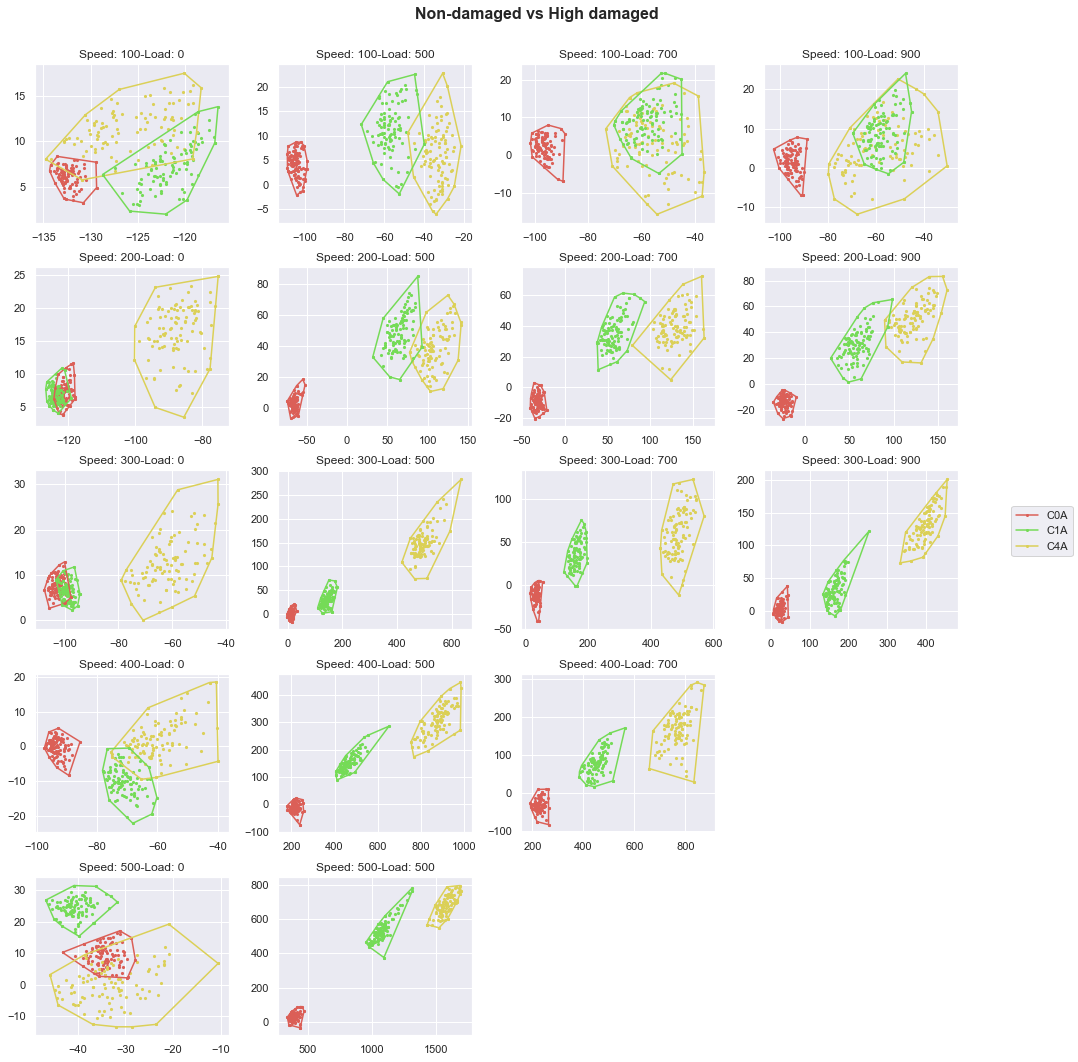

In [22]:
title = 'Non-damaged vs High damaged'
fig = compare(faults_=faults_[order_damage][[0,-1,-2]], title=title);

- When we compare the non-damage to the low damage (LD) tests, it is difficult to identify any pattern. The low speed test clusters (upper row) seems very mixed which might indicate that the system is not damaged enough (or it is not excited enough) to be detected. It is interesting to notice that when we increase the speed the clusters seems to separate a bit (compare speed 100 to speed 300). However the cases of Speed:500-Load:500 and Speed:400-Load:700 are quite mixed again. This might indicate that the motor is going out of their working regime where the possible unbalance from manufacturing defects, apply loads, natural frequencies, etc is affecting severely the response of the system. 

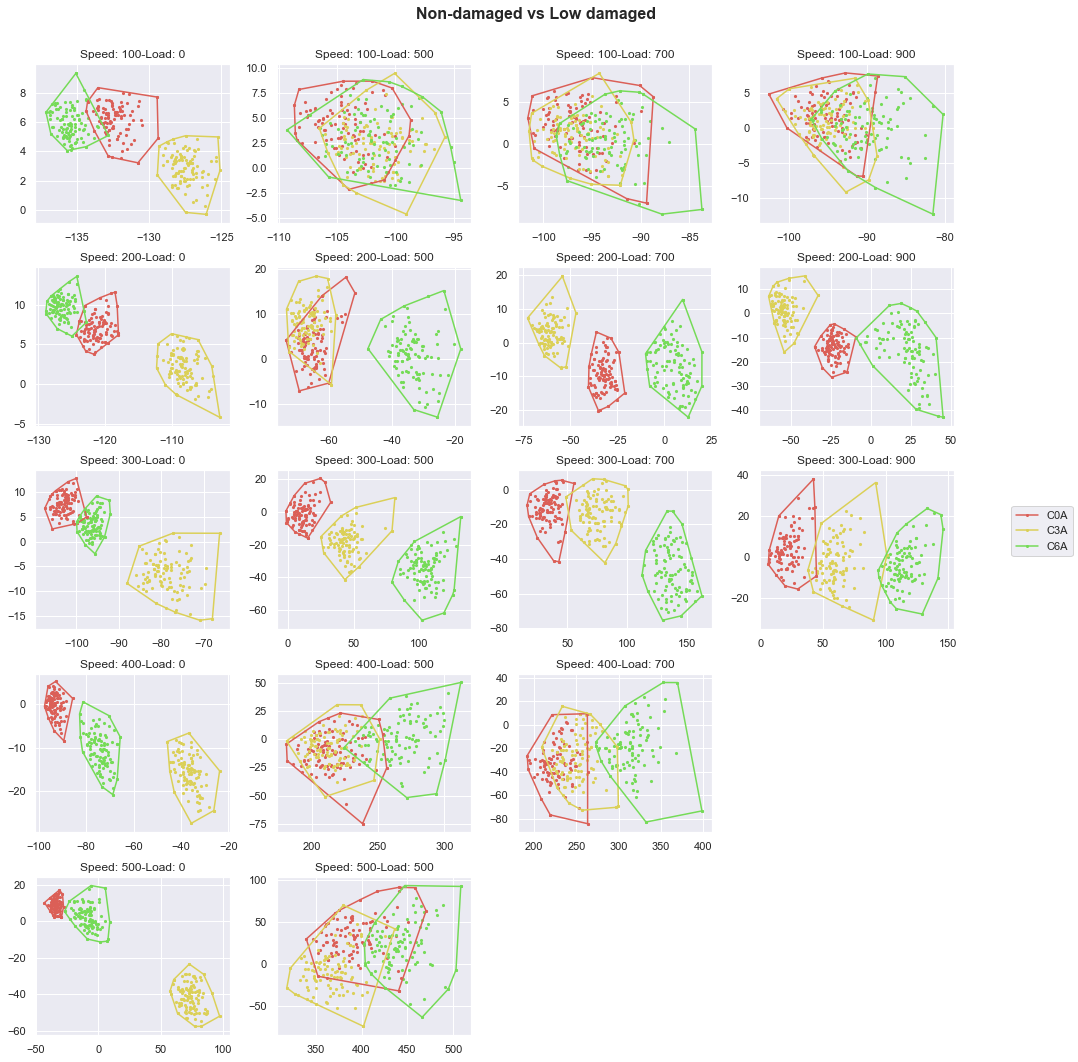

In [23]:
title = 'Non-damaged vs Low damaged'

fig = compare(faults_=faults_[order_damage][[0,1,2]], title=title);

- For the medium damaged (MD) tests we should probably expect results in between the LD and HD (if we assume linearity in the damage behavior, which is a *strong* assumption). These average behavior can be seen in the test which speeds are 300 or 400 and their load are 500 or 700. These test conform the center of the graph matrix which correspond to the frequent working conditions. In this situation the linearity of the system might be more clear due to:

    - The signal is not affected by high speed unbalance
    - The rotor is at working regime (probably not too far from it peak of performance, hence less vibrations and noise)
    - The load are not too high to produce unbalance. 

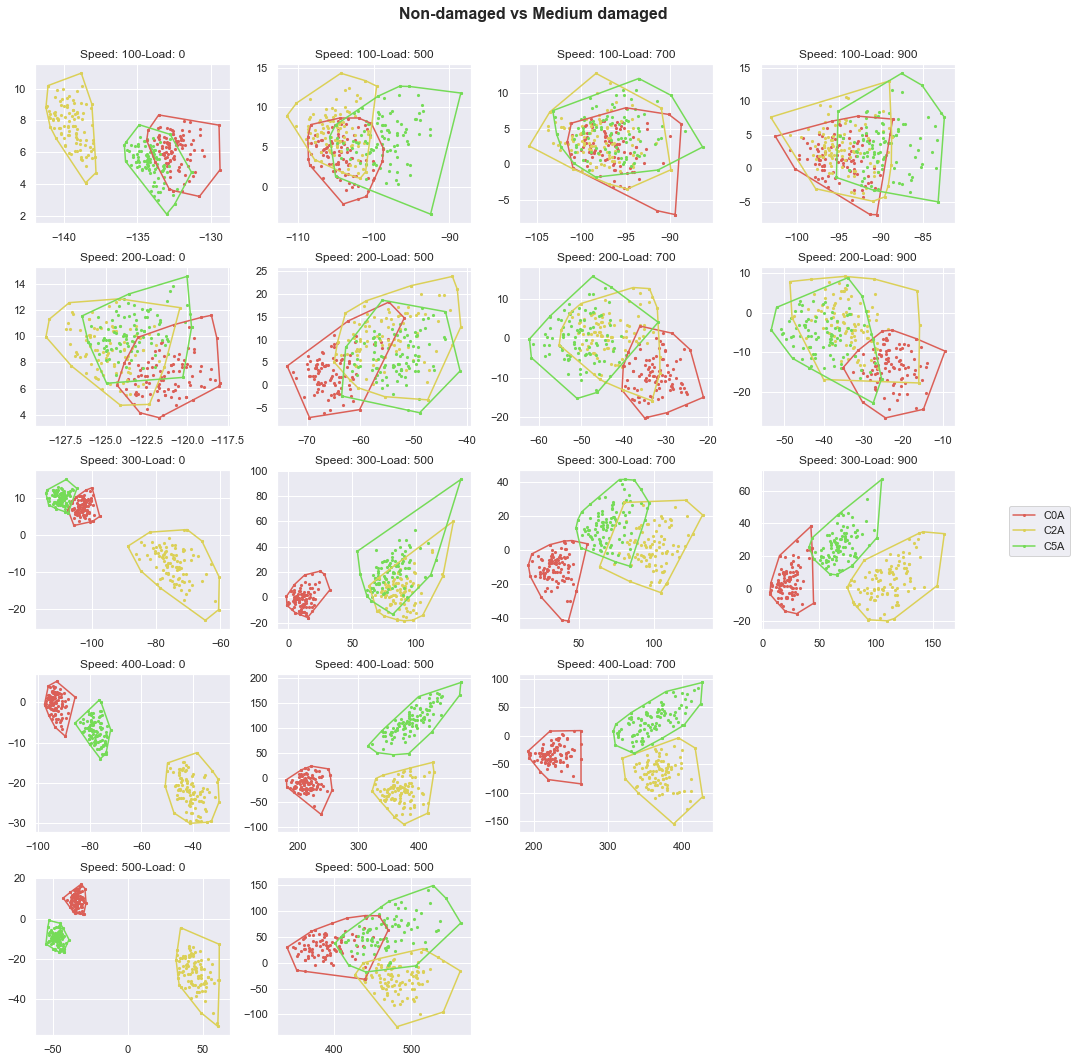

In [24]:
title = 'Non-damaged vs Medium damaged'
fig = compare(faults_=faults_[order_damage][[0,3,4]], title=title);

It should be notice that three effects are considered here: speed, load and damage/fault.
Let try to get some conclusions about each one. 

#### Speed

If we look at the first column of the ND-LD plot (No-load, no-damage). We see that increasing speed help to separate the clusters, which means the system gets more excited and the damage really impact its behavior.

#### Damage

In the cases where there is no load and the speed is low, the presence of damage can be recognised easily. However the differences between low damaged and high damaged are not very considerable compared with other combinations. Again, the lack of external excitation might made the behavior of the rotor agnostic to the damage.

#### Load

If we look at the first row in the ND-LD plot, we see the clusters are quite close to each other when the load is different to zero.

#### Speed-Damage

This pattern repeats for the MD and HD. In the case of the HD we can see how the extreme cases (speed 100 and 500) the distinction between clusters is not that clear, which might mean the damage behavior is hidden by vibration of the unbalance created by the damage.

#### Speed-Load

The relationship speed-load seems more complicated to describe probably because the load and speed are non-linearly correlated. It is interesting to bring up that the rotors normally have a torque-rotational speed fixed relationship depending on their manufacturing. As a example we present the next figure.

| ![Torque-Rotational speed relationship in an induction motor.](https://base.imgix.net/files/base/ebm/hydraulicspneumatics/image/2019/03/hydraulicspneumatics_1521_promo.png?auto=format&dpr=2&fit=crop&h=432&w=768) | 
|:-:| 
| *Torque-Rotational speed relationship in an induction motor.* Source: Hydraulic-Electric Analogies: Torque-Speed Behavior, Part 4 [https://www.hydraulicspneumatics.com/technologies/hydraulic-pumps-motors/article/21884785/hydraulicelectric-analogies-torquespeed-behavior-part-4 ] |


Depending on the position in the curve the rotor is working, the behavior is more or less clear. This curve might explain why low speeds (the bottom right corner, S500-L500,S400-L700) and high speed-high loads (top row, S100) presents mixed results.

I'm assuming mixed results means one of two things:
- The damage effect is hidden due to other effects highly powered (for example when we use high pairs speed-load)
- The system is not excited (pushed?) enough so there is no difference between damaged and non-damaged. 

It would be very interesting to know what the critical speed (speed where the natural frequency is excited) of the system because the system will behave different. We could use that to identify further damage by exciting the system in those frequencies. However I expect that the most of the natural frequencies of a rotor are going to be far from the operating frequencies for safety.

## Gaussian Mixture


In [25]:
#Training on the non-faulty
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

X = df[
    (df['Fault'].isin([0])) 
      ]
test_ = X['Test'].unique()

X = X.drop(columns_text,axis=1)


scaler = StandardScaler(with_mean=True,with_std=False)
# df[col] = StandardScaler(with_mean=True,with_std=False).fit_transform(df[col])

X = scaler.fit_transform(X)

X_train, X_test = train_test_split(X,test_size=0.2,train_size=0.8, random_state=1)

# from the PCA analysis
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X_train)

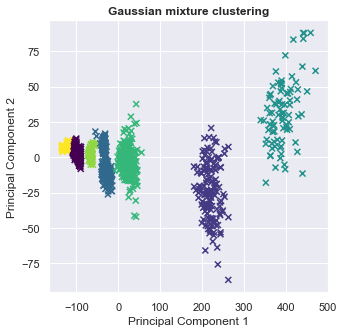

In [26]:
from sklearn.mixture import GaussianMixture
n_components = 7


gm = GaussianMixture(n_components =n_components, covariance_type = 'full', random_state=0,n_init=10 )
gm = gm.fit(X_pca)

## plotting clusters
plt.figure(figsize=(5,5))
ax = fig.subplots(1)
plt.scatter(X_pca[:,0],X_pca[:,1],c=gm.predict(X_pca),cmap='viridis',marker='x');#predict_proba
plt.title('Gaussian mixture clustering',fontweight="bold");
plt.xlabel('Principal Component 1');
plt.ylabel('Principal Component 2');


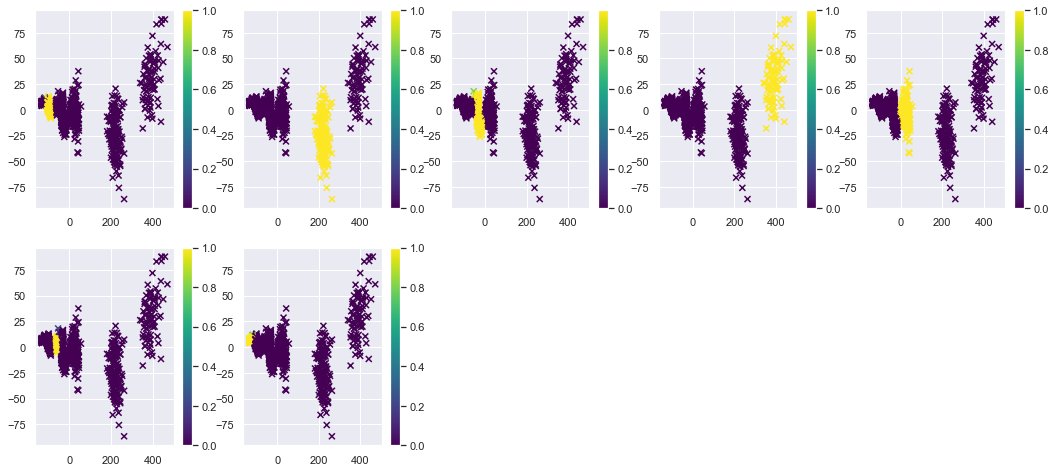

In [27]:
## Plotting probabilities
plt.figure(figsize=(18,8))

for i in range(n_components):
    plt.subplot(np.ceil(n_components/5),5,i+1)
    ax = plt.scatter(X_pca[:,0],X_pca[:,1],c=gm.predict_proba(X_pca)[:,i],cmap='viridis',marker='x') #predict_proba
    plt.colorbar(ax)

In [28]:
X = df[
    df['Fault'].isin([0,1,4])
].copy(deep=True)

X = df.copy(deep=True)

# Filtering set of test
X_test = X[
    (X['Fault'].isin([0])) 
      ]

n_test_health = len(X['Test'].unique())

X_HD = X[
    (X['Fault'].isin([1,4])) 
      ].drop(columns_text,axis=1)

X_MD = X[
    (X['Fault'].isin([2,5])) 
      ].drop(columns_text,axis=1)
X_LD = X[
    (X['Fault'].isin([3,6])) 
      ].drop(columns_text,axis=1)

X_train, X_test,X_train_lab,X_test_lab = train_test_split(X_test.drop(columns_text,axis=1), X_test['Test'],
                                                          test_size=0.2,train_size=0.8, random_state=1)

Number of components (optimal BIC): 10


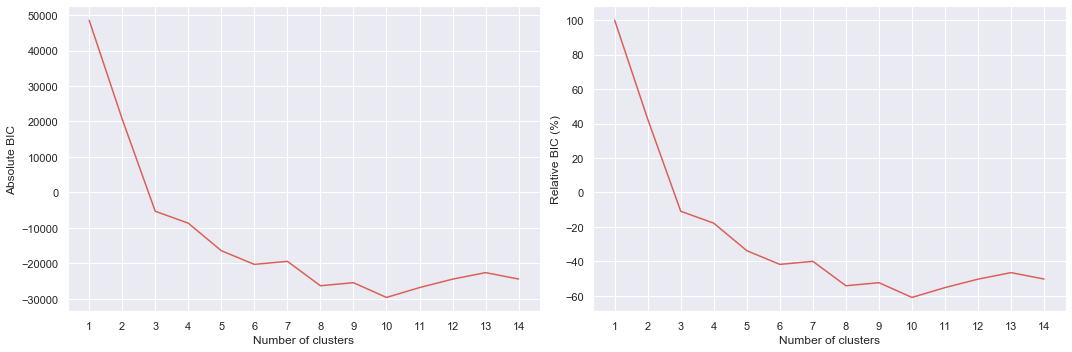

In [29]:
from sklearn.mixture import GaussianMixture

# evaluating number of components
bic = {}
for n_comp in range(1,15):
    gm = GaussianMixture(n_components =n_comp, covariance_type = 'full', random_state=0, n_init=2 )
    gm = gm.fit(X_train)
    bic[n_comp] = gm.bic(X_train)

n_components = min(bic.keys(),key=(lambda k: bic[k]))
print('Number of components (optimal BIC): {}'.format(n_components))

fig = plt.figure(figsize=(15,5))
ax = fig.subplots(ncols=2,nrows=1);

nclusters = list(bic.keys())
bic_values = list(bic.values())

# absolute data
ax[0].plot(nclusters,bic_values);
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Absolute BIC")  
ax[0].set_xticks(nclusters);

# Relative data 
percentages = [each/bic_values[0]*100 for each in bic_values]
ax[1].plot(nclusters, percentages);
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("Relative BIC (%)")   
ax[1].set_xticks(nclusters);

fig.tight_layout() 

In [30]:
# Training

gm = GaussianMixture(n_components =n_components, covariance_type = 'full', random_state=0, n_init=10)
gm.fit(X_train)

# Samples with lower probability than the threshold are considered damaged. 
threshold = 0.01  

def score_(X):
    score = gm.score_samples(X)
    probs_belong = np.exp(score) 
    outlier = probs_belong < threshold  

    print("Number of damaged samples: {}".format(sum(outlier)))
    print("Number of healthy samples: {}".format(len(outlier) - sum(outlier)))
    print("Percentage outliers/total: {:0.2f}%".format(100*sum(outlier)/len(outlier)))
    
    return outlier,score

print('\n====\nHealthy samples')
print('\nTraining set')
score_(X_train);

print('\nTesting set')
score_(X_test) ;


print('\n====\nDamaged samples')
print('\nHighly damaged')
score = score_(X_HD) ;

print('\nMedium damaged')
score = score_(X_MD) ;

print('\nLow damaged')
score = score_(X_LD) ;


====
Healthy samples

Training set
Number of damaged samples: 2
Number of healthy samples: 1358
Percentage outliers/total: 0.15%

Testing set
Number of damaged samples: 25
Number of healthy samples: 315
Percentage outliers/total: 7.35%

====
Damaged samples

Highly damaged
Number of damaged samples: 3400
Number of healthy samples: 0
Percentage outliers/total: 100.00%

Medium damaged
Number of damaged samples: 3338
Number of healthy samples: 62
Percentage outliers/total: 98.18%

Low damaged
Number of damaged samples: 3400
Number of healthy samples: 0
Percentage outliers/total: 100.00%


## Conclusions

Using machine learning algorithms we are able to detect damage by using only healthy data to train the algorithms. 
This method is simple but powerful enough to accurately separate damage signal from non-damage with accuracy higher than 95%. 

## Practical recommendations 
To detect damage in the system we need to increase the excitation/energy in the system by either increasing the speed or rotation and/or load. 

- **Default condition for detection:** To detect damage in the system it is recommended to run the rotor at speed around 300. At this speed, at any given damage level or load, the response is the system is different enough (clusters are far away from each other) to being able to detect damage. 

- **Sweep speed test:** In some cases, the default condition (speed:300) might not be appropriate, in that case, a sweep speed test (similar to sweep-sine test) is proposed. In this test, we increase or decrease gradually the speed of the rotor (no load is needed) in order to capture different behavior which helps us to identify better the damage. It seems that decrease the speed helps to increase the damage detection accuracy when the damage is not high (Compare row 300-row 200 in ND vs LD). On the opposite side, for improve damage detection in HD systems (and maybe MD) it seems it is recommended to increase the speed. However the clusters are quite different in the case of the HD and ideally we wouldn't want to reach that level.